# AI608 - Team project
- Team: Breaktime
- Team Member
    - 20195239 / Sumin Lim / sumin.lim@kaist.ac.kr
    - KR20590 NAVER / Soyoon Park / s0y00n.park@navercorp.com
    - KR17741 NAVER / Wonhong Yoo / wh.y@navercorp.com

- original paper (A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem): https://arxiv.org/abs/1706.10059
- reference project: https://github.com/liangzp/Reinforcement-learning-in-portfolio-management-

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context('paper', rc={'lines.linewidth': 1.5})
sns.set(rc={'figure.figsize':(10, 7.5)})

## Dataset

In [ ]:
import os
files = os.listdir('../input/allwhetheretf')
stocks = [file[:-4] for file in files]
stocks

In [ ]:
import pandas as pd
df_all = list()
for stock in stocks:
    file_path = f'../input/allwhetheretf/{stock}.csv'
    df = pd.read_csv(file_path, index_col=None, header=0)
    df['code'] =  pd.Series([str(stock)]*len(df), index=df.index)
    print(f'added stock={stock}, len={len(df)}')
    df_all.append(df)
    
df_all = pd.concat(df_all, ignore_index=True)

df_all = df_all.rename(columns={'Date': 'date',
                                'Open': 'open',
                                'High': 'high',
                                'Low' : 'low',
                                'Close': 'close',
                                'Volume': 'volume',
                               })
df_all['date'] = pd.to_datetime(df_all['date'], format='%Y. %m. %d')
df_all = df_all.set_index('date')
df_all = df_all.sort_index()
df_all

In [ ]:
fig, ax = plt.subplots(figsize=(17.5, 10))
sns.lineplot(data=df_all, x='date', y='close', hue='code')
plt.title('Stock Close Price in All Whether Portfolio\n', size=20)
plt.xlabel('Time', size=15)
plt.ylabel('Close Price', size=15)
plt.legend(bbox_to_anchor=(1.1, 1.01), loc='upper right')
ax.legend_.set_title('Stock Ticker')

# configuration

In [ ]:
import datetime
runtime_version = datetime.datetime.now().isoformat()
print(runtime_version)

In [ ]:
config = {
    "market_types":"AllWheter",
    "start_date": "2010-07-23",
    "end_date": "2020-12-31",
    "asset_length": 9,  # total assets 
    "features":["close","high"],
    "agents": {
        "window_length": 40
    },
    "epochs": 200,
    "noise_flag": True,
    "record_flag": True,
    "plot_flag": True,
    "reload_flag": False,
    "trainable": True,
    "method": "model_free"
}

In [ ]:
def parse_config(config, mode):
    asset_length = config["asset_length"]
    start_date = config["start_date"]
    end_date = config["end_date"]
    features = config["features"]
    market = config["market_types"]
    noise_flag, record_flag, plot_flag=config["noise_flag"],config["record_flag"],config["plot_flag"]
    agent_config = config['agents']
    window_length = agent_config['window_length']
    reload_flag, trainable = config['reload_flag'],config['trainable']
    method = config['method']

    epochs = int(config["epochs"])

    if mode == 'test':
        record_flag=True
        noise_flag=False
        plot_flag=True
        reload_flag=True
        trainable=False
        method='model_free'

    print("*--------------------Training Status-------------------*")
    print("Date from",start_date,' to ',end_date)
    print('Features:',features)
    print("Agent: Noise(",noise_flag,')---Record(',record_flag,')---Plot(',plot_flag,')')
    print("Market Type:",market)
    print("Window_length:",window_length)
    print("Epochs:",epochs)
    print("Trainable:",trainable)
    print("Reloaded Model:",reload_flag)
    print("Method",method)
    print("Noise_flag",noise_flag)
    print("Record_flag",record_flag)
    print("Plot_flag",plot_flag)


    return asset_length,start_date,end_date,features,market, window_length,noise_flag, record_flag, plot_flag,reload_flag,trainable,method, epochs


In [ ]:
asset_length, start_date, end_date, features, market, window_length, noise_flag, record_flag, plot_flag, reload_flag, trainable, method, epochs = parse_config(config, 'train')

In [ ]:
M = asset_length + 1
M

# Input DATASET

In [ ]:
data_df = df_all

# Environment

In [ ]:
import numpy as np
import pandas as pd
from math import log
from datetime import datetime
import time
import random

eps = 10e-8

def fill_zeros(x):
    return '0'*(6-len(x))+x


class Environment:
    def __init__(self):
        self.cost=0.0025

    def get_repo(self, data_df, start_date, end_date, codes_num, market):
        #preprocess parameters

        #read all data
        self.data=data_df
        self.data["code"]=self.data["code"].astype(str)
        if market=='China':
            self.data["code"]=self.data["code"].apply(fill_zeros)

        sample_flag=True
        while sample_flag:
            codes=random.sample(set(self.data["code"]), codes_num)
            data2=self.data.loc[self.data["code"].isin(codes)]

            date_set=set(data2.loc[data2['code']==codes[0]].index)
            for code in codes:
                date_set=date_set.intersection((set(data2.loc[data2['code']==code].index)))
            if len(date_set)>1200:
                sample_flag=False

        date_set=date_set.intersection(set(pd.date_range(start_date,end_date)))
        self.date_set = list(date_set)
        self.date_set.sort()

        train_start_time = self.date_set[0]
        train_end_time = self.date_set[int(len(self.date_set) / 6) * 5 - 1]
        test_start_time = self.date_set[int(len(self.date_set) / 6) * 5]
        test_end_time = self.date_set[-1]

        return train_start_time,train_end_time,test_start_time,test_end_time,codes

    def get_data(self, data_df, start_time,end_time,features,window_length,market,codes):
        self.codes=codes

        self.data = data_df
        self.data["code"] = self.data["code"].astype(str)
        if market == 'China':
            self.data["code"] = self.data["code"].apply(fill_zeros)

        self.data[features]=self.data[features].astype(float)
        self.data=self.data[start_time.strftime("%Y-%m-%d"):end_time.strftime("%Y-%m-%d")]
        data=self.data
        #TO DO:REFINE YOUR DATA

        #Initialize parameters
        self.M=len(codes)+1
        self.N=len(features)
        self.L=int(window_length)
        self.date_set=pd.date_range(start_time,end_time)
        # create pandas format dataset
        asset_dict=dict() # asset data
        for asset in codes:
            asset_data=data[data["code"]==asset].reindex(self.date_set).sort_index()
            
            # 데이터 단위를 'D' 일단위로 조정
            asset_data = asset_data.resample('D').mean()
            
            
            asset_data['close']=asset_data['close'].fillna(method='pad')
            # base_price = asset_data.ix[-1, 'close']
            base_price = asset_data['close'][-1]
            asset_dict[str(asset)]= asset_data
            asset_dict[str(asset)]['close'] = asset_dict[str(asset)]['close'] / base_price

            if 'high' in features:
                asset_dict[str(asset)]['high'] = asset_dict[str(asset)]['high'] / base_price

            if 'low' in features:
                asset_dict[str(asset)]['low']=asset_dict[str(asset)]['low'] / base_price

            if 'open' in features:
                asset_dict[str(asset)]['open']=asset_dict[str(asset)]['open'] / base_price

            asset_data=asset_data.fillna(method='bfill',axis=1)
            asset_data=asset_data.fillna(method='ffill',axis=1)
            #***********************open as preclose*******************#
            #asset_data=asset_data.dropna(axis=0,how='any')
            asset_dict[str(asset)]=asset_data

        ## tensor format
        self.states=[]
        self.price_history=[]
        self.real_close_prices=[]
        t =self.L+1
        length=len(self.date_set)
        while t<length-1:
            V_close = np.ones(self.L)
            if 'high' in features:
                V_high=np.ones(self.L)
            if 'open' in features:
                V_open=np.ones(self.L)
            if 'low' in features:
                V_low=np.ones(self.L)


            y=np.ones(1)
            state=[]
            for asset in codes:
                asset_data=asset_dict[str(asset)]
                
                # Portfolio-Vector Memory
                # [t - self.L - 1:t - 1]
                V_close = np.vstack((V_close, asset_data['close'].iloc[t - self.L - 1:t - 1]))
                if 'high' in features:
                    V_high=np.vstack((V_high,asset_data['high'].iloc[t-self.L-1:t-1]))
                if 'low' in features:
                    V_low=np.vstack((V_low,asset_data['low'].iloc[t-self.L-1:t-1]))
                if 'open' in features:
                    V_open=np.vstack((V_open,asset_data['open'].iloc[t-self.L-1:t-1]))
                y=np.vstack((y,asset_data['close'].iloc[t]/asset_data['close'].iloc[t-1]))
            state.append(V_close)
            if 'high' in features:
                state.append(V_high)
            if 'low' in features:
                state.append(V_low)
            if 'open' in features:
                state = np.stack((state,V_open), axis=2)

            state=np.stack(state,axis=1)
            state = state.reshape(1, self.M, self.L, self.N)
            self.states.append(state)
            self.price_history.append(y)
            self.real_close_prices.append(V_close)
            t=t+1
        self.reset()


    def step(self, w1, w2, noise, step_unit = 1):
        if self.FLAG:
            not_terminal = 1
            
            price = self.price_history[self.t]
            close = self.real_close_prices[self.t]
            
            # noise
            if noise:
                price = price + np.stack(np.random.normal(0, 0.002, (1,len(price))), axis=1)
            
            mu = self.cost * (np.abs(w2[0][1:] - w1[0][1:])).sum()

            # std = self.states[self.t - 1][0].std(axis=0, ddof=0)
            # w2_std = (w2[0]* std).sum()

            # #adding risk
            # gamma=0.00
            # risk=gamma*w2_std

            risk=0
            r = (np.dot(w2, price)[0] - mu)[0]


            reward = np.log(r + eps)

            w2 = w2 / (np.dot(w2, price) + eps)
            self.t += step_unit
            if self.t >= len(self.states):
                not_terminal = 0
                self.reset()

            price = np.squeeze(price)
            info = {'reward': reward, 'continue': not_terminal, 'next state': self.states[self.t],
                    'weight vector': w2, 'price': price, 'risk':risk, 'close': close}
            return info
        else:
            info = {'reward': 0, 'continue': 1, 'next state': self.states[self.t],
                        'weight vector': np.array([[1] + [0 for i in range(self.M-1)]]),
                        'price': self.price_history[self.t],'risk':0, 'close':self.real_close_prices[self.t]}

            self.FLAG=True
            return info

    def reset(self):
        self.t=self.L+1
        self.FLAG = False

    def get_codes(self):
        return self.codes

In [ ]:
env = Environment()

In [ ]:
train_start_date, train_end_date, test_start_date, test_end_date, codes = env.get_repo(data_df, start_date, end_date, asset_length, market)

In [ ]:
print("Codes:", codes)
print('Training Time Period:', train_start_date, '~', train_end_date)
print('Testing Time Period:', test_start_date, '~', test_end_date)

## setup environment data

In [ ]:
env.get_data(data_df, train_start_date, train_end_date, features, window_length, market, codes)

# Agent

In [ ]:
!pip install tflearn==0.5.0

In [ ]:
output_dir = '/kaggle/working/result'

In [ ]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tflearn
import numpy as np
import os


class PG:
    def __init__(self,M,L,N,name,load_weights,trainable,noise_flag,runtime_version):
        # Initial buffer
        self.buffer = list()
        self.name = name
        self.learning_rate=10e-3
        self.runtime_version=str(runtime_version)
        self.noise_flag=noise_flag
        # Build up models
        tf.reset_default_graph()
        self.sesson = tf.Session()

        # Initial input shape
        self.M = M
        self.L = L
        self.N = N
        self.global_step = tf.Variable(0, trainable = False)

        self.state, self.w_previous, self.out = self.build_net()
        self.future_price = tf.placeholder(tf.float32,[None] + [self.M])
        self.pv_vector = tf.reduce_sum(self.out * self.future_price, reduction_indices=[1]) * self.pc()
        self.profit = tf.reduce_prod(self.pv_vector)
        self.loss = -tf.reduce_mean(tf.log(self.pv_vector))
        self.optimize=tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss,global_step=self.global_step)

        # Initial saver
        self.saver = tf.train.Saver(max_to_keep=10)

        if load_weights:
            print("Loading Model")
            try:
                checkpoint_dir = f'{output_dir}/{self.runtime_version}/PG/saved_network/'+str(noise_flag)+'/'
                print(f'checkpoint dir: {checkpoint_dir}')
                checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
                if checkpoint and checkpoint.model_checkpoint_path:
                    print("start restore")
                    self.saver.restore(self.sesson, checkpoint.model_checkpoint_path)
                    print("Successfully loaded:", checkpoint.model_checkpoint_path)
                else:
                    raise Exception("Could not find old network weights")
                    # self.sesson.run(tf.global_variables_initializer())

            except:
                raise Exception("Could not find old network weights")
                # self.sesson.run(tf.global_variables_initializer())
        else:
            self.sesson.run(tf.global_variables_initializer())

        if trainable:
            # Initial summary
            self.summary_writer = tf.summary.FileWriter(f'{output_dir}/{self.runtime_version}/PG/summary/'+str(noise_flag)+'/', self.sesson.graph)
            self.summary_ops, self.summary_vars = self.build_summaries()


    # setup policy gradient neural network (edited)
    def build_net(self):
        state=tf.placeholder(tf.float32,shape=[None]+[self.M]+[self.L]+[self.N],name='market_situation')
        network = tflearn.layers.conv_2d(state, 2,
                                         [1, 2],
                                         [1, 1, 1, 1],
                                         'valid',
                                         'relu')
        width = network.get_shape()[2]
        network = tflearn.layers.conv_2d(network, 48,
                                         [1, width],
                                         [1, 1],
                                         "valid",
                                         'relu',
                                         regularizer="L2",
                                         weight_decay=5e-9)
        w_previous=tf.placeholder(tf.float32,shape=[None,self.M])
        network=tf.concat([network,tf.reshape(w_previous, [-1, self.M, 1, 1])],axis=3)
        network = tflearn.layers.conv_2d(network, 1,
                                         [1, network.get_shape()[2]],
                                         [1, 1],
                                         "valid",
                                         'relu',
                                         regularizer="L2",
                                         weight_decay=5e-9)
        network=tf.layers.flatten(network)
        w_init = tf.random_uniform_initializer(-0.005, 0.005)
        out = tf.layers.dense(network, self.M, activation=tf.nn.softmax, kernel_initializer=w_init)

        return state,w_previous,out

    def pc(self):
        return 1 - tf.reduce_sum(tf.abs(self.out[:, 1:] - self.w_previous[:, 1:]), axis=1) * 0.0025

    # action (edited)
    def predict(self,s,a_previous):
        return self.sesson.run(self.out,feed_dict={self.state:s,self.w_previous:a_previous})

    # current round transition (edited)
    def save_transition(self, s, p, action,action_previous):
        self.buffer.append((s, p, action,action_previous))

    # update parameter to train (edited)
    def train(self):
        s,p,a,a_previous=self.get_buffer()
        profit,_= self.sesson.run([self.profit,self.optimize],feed_dict={
            self.state: s,
            self.out: np.reshape(a,(-1, self.M)),
            self.future_price: np.reshape(p,(-1, self.M)),
            self.w_previous: np.reshape(a_previous,(-1, self.M))
        })

    def get_buffer(self):
        s = [data[0][0] for data in self.buffer]
        p = [data[1] for data in self.buffer]
        a = [data[2] for data in self.buffer]
        a_previous = [data[3] for data in self.buffer]
        return s, p,a,a_previous

    def reset_buffer(self):
        self.buffer = list()

    def save_model(self):
        path=f'{output_dir}/{self.runtime_version}/PG/saved_network/'+ str(self.noise_flag) +'/'
        if not os.path.exists(path):
            os.makedirs(path)
        self.saver.save(self.sesson,path+self.name,global_step=self.global_step)

    def write_summary(self,reward):
        summary_str = self.sesson.run(self.summary_ops, feed_dict={
            self.summary_vars[0]: reward,
        })
        self.summary_writer.add_summary(summary_str, self.sesson.run(self.global_step))

    def close(self):
        self.sesson.close()

    def build_summaries(self):
        self.reward = tf.Variable(0.)
        tf.summary.scalar('Reward', self.reward)
        summary_vars = [self.reward]
        summary_ops = tf.summary.merge_all()
        return summary_ops, summary_vars

# Train

In [ ]:
import math
from decimal import Decimal
import numpy as np
import matplotlib.pyplot as plt

class StockTrader():
    def __init__(self):
        self.reset()

    def reset(self):
        self.wealth = 10e3
        self.total_reward = 0
        self.ep_ave_max_q = 0
        self.loss = 0
        self.actor_loss=0

        self.wealth_history = []
        self.r_history = []
        self.w_history = []
        self.p_history = []

    def update_summary(self,loss,r,q_value,actor_loss,w,p):
        self.loss += loss
        self.actor_loss+=actor_loss
        self.total_reward+=r
        self.ep_ave_max_q += q_value
        self.r_history.append(r)
        self.wealth = self.wealth * math.exp(r)
        self.wealth_history.append(self.wealth)
        self.w_history.extend([','.join([str(Decimal(str(w0)).quantize(Decimal('0.00'))) for w0 in w.tolist()[0]])])
        self.p_history.extend([','.join([str(Decimal(str(p0)).quantize(Decimal('0.000'))) for p0 in p.tolist()])])

    def write(self, agent_name: str, epoch = '', codes = [], prefix_dir=''):
        
        wealth_history = pd.Series(self.wealth_history)
        r_history = pd.Series(self.r_history)
        w_history = pd.Series(self.w_history)
        p_history = pd.Series(self.p_history)
        history = pd.concat([wealth_history, r_history, w_history, p_history], axis=1, keys=['wealth', 'reward', 'weight', 'price'])
        dir_path = f'{output_dir}/{prefix_dir}'
        file_path = f'{dir_path}/{agent_name}-{epoch}-{"_".join(codes)}-{str(math.exp(np.sum(self.r_history)) * 100)}.csv'
        os.makedirs(dir_path, exist_ok=True)
        history.to_csv(file_path)

    def print_result(self,epoch,agent,noise_flag):
        self.total_reward=math.exp(self.total_reward) * 100
        print('*-----Episode: {:d}, Reward:{:.6f}%-----*'.format(epoch, self.total_reward))
        agent.write_summary(self.total_reward)
        agent.save_model()

    def plot_result(self):
        pd.Series(self.wealth_history).plot()
        plt.show()



In [ ]:
def parse_info(info):
    return info['reward'],info['continue'],info[ 'next state'],info['weight vector'], info['price'], info['risk'], info['close']

In [ ]:
def traversal(stocktrader,agent,env,epoch,noise_flag,framework,method,trainable):
    info = env.step(None,None,noise_flag)
    r,contin,s,w1,p,risk,_=parse_info(info)
    contin=1
    t=0

    while contin:
        w2 = agent.predict(s, w1)
        env_info = env.step(w1, w2, noise_flag)
        r, contin, s_next, w1, p, risk, _ = parse_info(env_info)

        if framework=='PG':
            agent.save_transition(s,p,w2,w1)
        else:
            agent.save_transition(s, w2, r-risk, contin, s_next, w1)
        loss, q_value,actor_loss=0,0,0

        if framework=='DDPG':
            if not contin and trainable:
                agent_info= agent.train(method,epoch)
                loss, q_value=agent_info["critic_loss"],agent_info["q_value"]
                if method=='model_based':
                    actor_loss=agent_info["actor_loss"]

        elif framework=='PPO':
            if not contin and trainable:
                agent_info = agent.train(method, epoch)
                loss, q_value = agent_info["critic_loss"], agent_info["q_value"]
                if method=='model_based':
                    actor_loss=agent_info["actor_loss"]

        elif framework=='PG':
            if not contin and trainable:
                agent.train()

        stocktrader.update_summary(loss,r,q_value,actor_loss,w2,p)
        s = s_next
        t=t+1


In [ ]:
stocktrader = StockTrader()

In [ ]:
print("*-----------------Loading PG Agent---------------------*")
agent = PG(len(codes) + 1, int(window_length), len(features), 'pg_agent_name', reload_flag,
           trainable,noise_flag, runtime_version)

print("Training with {:d}".format(epochs))
for epoch in range(epochs):
    print("Now we are at epoch", epoch)
    traversal(stocktrader, agent, env, epoch, noise_flag, 'PG', method, trainable)

    if record_flag:
        stocktrader.write(epoch=epoch, agent_name='PG', prefix_dir=f'{runtime_version}/PG/train')

    if plot_flag:
        stocktrader.plot_result()

    agent.reset_buffer()
    stocktrader.print_result(epoch, agent, noise_flag)
    stocktrader.reset()
agent.close()
del agent

# Baseline

In [ ]:
import numpy as np

# Uniform CRP(Constant Rebalanced Portfolio)
class UCRP:
    def __init__(self):
        self.a_dim=0

    def predict(self,s,a):
        weights=np.ones(len(a[0]))/len(a[0])
        weights=weights[None,:]
        return weights

In [ ]:
import numpy as np

class WINNER:
    def __init__(self):
        self.a_dim=0

    def predict(self,s,a):
        close=[]
        for i,prices in enumerate(s[0]):
            closes=prices[-1]
            close.append(closes[-1]/closes[-2])
        weights = np.zeros(len(s[0]))
        weights[np.argmax(close)] = 1
        weights = weights[None,:]
        return weights

In [ ]:
import numpy as np

class LOSSER:
    def __init__(self):
        self.a_dim=0

    def predict(self,s,a):
        close = []
        for i, prices in enumerate(s[0]):
            closes = prices[-1]
            close.append(closes[-1] / closes[-2])
        weights = np.zeros(len(s[0]))
        weights[np.argmin(close)] = 1
        weights = weights[None, :]
        return weights

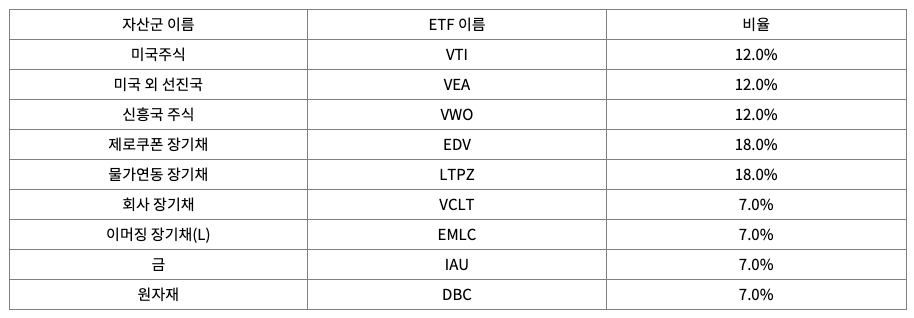

In [ ]:
class RayDalio:
    def __init__(self, codes):
        ratio = {
            'risk-free' : 0.0,
            'vti' : 0.12,
            'vea' : 0.12,
            'vwo' : 0.12,
            'edv' : 0.18,
            'ltpz' : 0.18,
            'vclt' : 0.07,
            'emlc' : 0.07,
            'iau' : 0.07,
            'dbc' : 0.07,
        }
        self.ratio = [0.0] + [ratio[code] for code in codes]

    def predict(self, state, w1):
        weights = np.array(self.ratio)
        weights = weights[None, :]
        return weights

In [ ]:
class VTI:
    def __init__(self, codes):
        ratio = {
            'risk-free' : 0.0,
            'vti' : 1.0,
            'vea' : 0.0,
            'vwo' : 0.0,
            'edv' : 0.0,
            'ltpz' : 0.0,
            'vclt' : 0.0,
            'emlc' : 0.0,
            'iau' : 0.0,
            'dbc' : 0.0,
        }
        self.ratio = [0.0] + [ratio[code] for code in codes]

    def predict(self, state, w1):
        weights = np.array(self.ratio)
        weights = weights[None, :]
        return weights

# TEST

In [ ]:
env.reset()

In [ ]:
agents=[]

pg_name = 'pg_agent_name'
load_weights_to_init = True
trainable_to_init = False
noise_flag_to_load = noise_flag 

step_units = list()
labels = list()
for step_unit in [1]:
    agents.extend(
        [PG(
            (len(codes) + 1), int(window_length), len(features), 
            pg_name, 
            load_weights_to_init, trainable_to_init, noise_flag_to_load, 
            runtime_version
        )]
    )
    step_units.append(step_unit)
    labels.append(f"PG-codes{len(codes)+1}-win{window_length}-feat{len(features)}")

agents.append(WINNER())
agents.append(UCRP())
agents.append(LOSSER())
agents.append(RayDalio(codes))
agents.append(VTI(codes))
labels.extend(['Winner','UCRP','Losser', 'RayDailo', 'VTI'])
step_units.extend([200, 1, 200, 1, 1])

wealths_result = list()
rs_result = list()
w_result = list()
for i, agent in enumerate(agents):
    stocktrader = StockTrader()
    agent_name = labels[i]
    noise_flag_to_step = False
    info = env.step(None, None, noise_flag_to_step)
    r, contin, s, w1, p, risk, close = parse_info(info)
    contin = 1
    wealth = 10000.
    wealths = [wealth]
    rs=[1]
    w = [w1]
    while contin:
        w2 = agent.predict(s, w1)
        env_info = env.step(w1, w2, noise_flag_to_step, step_unit=step_units[i])
        r, contin, s_next, w1, p, risk, close = parse_info(env_info)
        wealth = wealth * math.exp(r)
        for _ in range(step_units[i]):
            rs.append(math.exp(r)-1)
            wealths.append(wealth)
            w.append(w2)
        s = s_next
        stocktrader.update_summary(0, r, 0, 0, w2, p)

    stocktrader.write(codes=map(lambda x: str(x), env.get_codes()), agent_name=labels[i], prefix_dir=f'{runtime_version}/PG/test')
    print(f'finish agent "{labels[i]}"')
    wealths_result.append(wealths)
    rs_result.append(rs)
    w_result.append(w)

result_report_arr = []
# print('asset name','\t','daily average rate of return','\t','Sharpe rate','\t','maximum drawdown')
for i in range(len(agents)):
    mrr=float((wealths_result[i][-1] - wealths_result[i][0])*100 / wealths_result[0][0])
    sharpe=float(np.mean(rs_result[i])/np.std(rs_result[i])*np.sqrt(252))
    maxdrawdown=float(max(1-min(wealths_result[i])/np.maximum.accumulate(wealths_result[i])))
    result_report_arr.append([labels[i], f'{round(mrr,3)}%', round(sharpe,3), round(maxdrawdown,3)])
    # print(labels[i],'\t',round(mrr,3),'%','\t',round(sharpe,3),'\t',round(maxdrawdown,3))

result_report = pd.DataFrame(result_report_arr, columns=['asset name', 'total rate of return', 'Sharpe rate', 'maximum drawdown'])

In [ ]:
result_report

In [ ]:
for i in range(len(agents)):
    plt.plot(wealths_result[i], label=labels[i])
plt.legend()
plt.show()

In [ ]:
for agent in labels:
    w = np.stack(w_result[labels.index(agent)]).squeeze(1)
    w = pd.DataFrame(w, columns=['risk-free']+codes)
    for stock in ['risk-free']+codes :
        plt.plot(w[stock], label=stock)
    plt.legend()
    plt.title(f"Portfolio Weights for agent {agent}")
    plt.show()

In [ ]:
plt.savefig(f'{output_dir}/{runtime_version}/PG/test/backtest.png')

In [ ]:
import os

result_dir = f'{output_dir}/{runtime_version}/PG/test'
result_file_list = os.listdir(result_dir)
result_file_list = filter(lambda file: file.endswith('.csv'), result_file_list)

df_dict = {file: pd.read_csv(f'{result_dir}/{file}') for file in result_file_list}

keys = df_dict.keys()

for key in df_dict:
    df = df_dict[key]
    df = df[['wealth']]
    df.plot(title=key)